# Prerequisites

### Know how to specifiy array elements using indexing (e.g. y[3], array[:,0])

### Know how to draw some basic plots

### Know how to make a simple animation with ffmpeg

# Import required modules

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt

import numpy as np

# A particle in an infinite Potential Well ('box')

### Because $V(x)=\infty$ for $x<x_{min}$ and $x_{max}<x$
### $\psi(x_{min})=0$ and $\psi(x_{max})=0$

### Thus, we will only consider $\psi$ values at 'inside': from $x_{min}+\Delta{x}$ to $x_{max}-\Delta{x}$

## Configure spatial grid

In [2]:
## Parameters for spatial grid (specified by 'x', in this 1D model)
N_x = 50   # number of grid points
delta_x = 0.1   # grid interval (assuming equi-distanced grid)
x_min = 0   # lower bound of potential well (it may be different from minimum value of spatial grid)

### $x_{0}=x_{min}+\Delta{x}$

In [3]:
x_0 = x_min + delta_x   # first element ('x[0]') of a spatial array ('x_array')

### $x_{n} = x_0 + n\Delta{x}$ where $n=0,1,2,...,N_{x}-1$

In [4]:
n = np.arange(N_x)   # n = [0, 1, 2, ... , N_x - 1]
x_array = x_0 + n*delta_x

### $x_{N_{x}-1}=x_{max}-\Delta{x}$

In [5]:
x_max = x_array[N_x - 1] + delta_x

### $box\,size = x_{max} - x_{min}$

In [6]:
box_size = x_max - x_min

## Configure potential function (array)

#### Harmonic potential
$V(x) = k(x-x_{mid})^2$

In [7]:
## Set potential energy array in position representation

mid_x = 0.5 * (x_min + x_max)
k = 1.0

potential_energy_array = k * (x_array - mid_x)**2  # harmonic potential

<IPython.core.display.Javascript object>


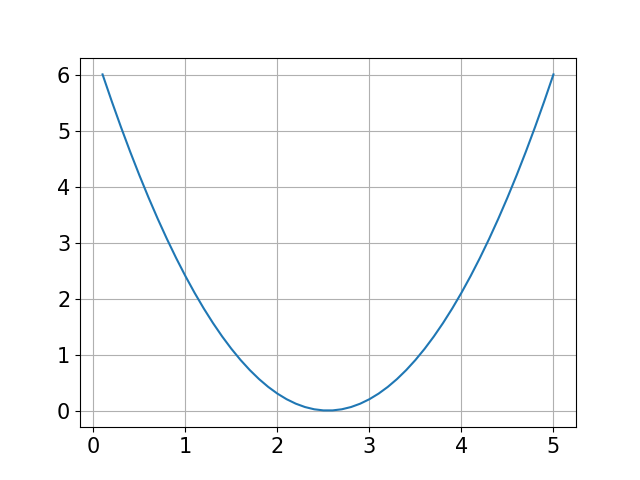

In [8]:
plt.plot(x_array, potential_energy_array)

# Construct Hamiltonian matrix

In [9]:
matrix_shape = [N_x, N_x]  # Think about why the matrix is N_x by N_x matrix

## Construct Kinetic Energy matrix (KE)

\begin{equation}
KE
\approx
-\frac{\hbar^2}{2m}
\frac{1}{\Delta{x}^2}
\begin{bmatrix}
    -2 & 1 & 0 & \dots & 0 & 0 & 0\\
    1 & -2 & 1 & \dots & 0 & 0 &0\\
    0 & 1 & -2 & \dots & 0 & 0 & 0\\
    \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & \vdots \\
    0 & 0 & 0 & \dots & -2 & 1 & 0 \\
    0 & 0 & 0 & \dots & 1 & -2 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 & -2
\end{bmatrix}
\end{equation}

In [10]:
KE = np.zeros(matrix_shape)  # kinetic_energy_matrix

# Using atomic unit system
hbar = 1
m = 1

# Caclulate coefficient
coefficient = - hbar**2 / (2 * m) * 1.0 / (delta_x**2)

## Fill diagonal elements
diagonal_element = - 2.0 * coefficient
for i in range(N_x):
    j = i
    KE[i,j] = diagonal_element

## Fill offdiagonal elements
off_diagonal_element = 1.0 * coefficient
# Fill lower-offdiagonal
for i in range(1,N_x):
    j = i - 1
    KE[i,j] = off_diagonal_element

# Fill upper-offdiagonal
for i in range(0,N_x-1):
    j = i + 1
    KE[i,j] = off_diagonal_element

## Construct potential energy matrix

In [11]:
PE = np.zeros(matrix_shape)  # potential_energy_matrix

# fill diagonal
for i in range(N_x):
    PE[i,i] = potential_energy_array[i]

## Construct Hamiltonian matrix

In [12]:
hamiltonian = KE + PE

# Obtain eigenenergy and eigenvectors
### We use numpy.linalg.eigh() function
### This funciton returns the eigenvalues and eigenvectors of a Hermitian matrix

In [13]:
eigen_values, eigen_vectors = np.linalg.eigh(hamiltonian)

# Time evolution

## Prepare shifted ground state as an initial state
Let $\psi_{0}(x)$ be the ground state of the system. Then, let's define the initial state as a ground state which is shifted in a position space by $\mu$

\begin{equation}
\psi(x,t_{0}) = \psi_{0}(x-\mu)
\end{equation}

In [14]:
test_psi = np.empty(N_x)

N_shift = 5  # Shift by 'N_shift * delta_x'
mu = N_shift * delta_x

ground_state = eigen_vectors[:,0]
test_psi[N_shift:] = ground_state[:-N_shift]
test_psi[:N_shift] = 0

### Plot the initial state

<IPython.core.display.Javascript object>


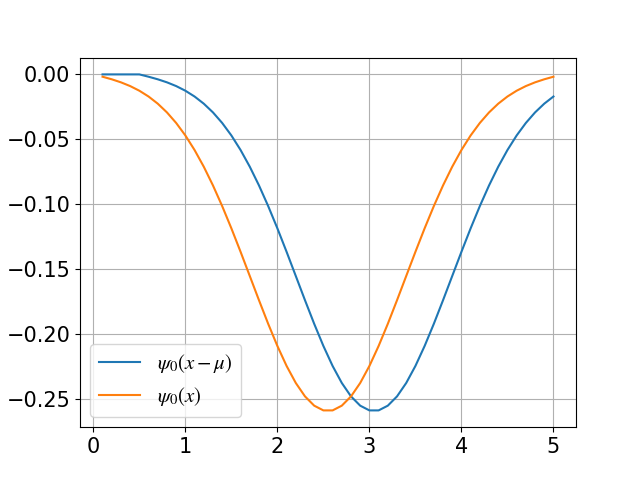

In [15]:
fig, ax = plt.subplots()

ax.plot(x_array, test_psi, label=r'$\psi_{0}(x-\mu)$')
ax.plot(x_array, ground_state, label=r'$\psi_{0}(x)$')

ax.legend()

## Calculate components with energy eigenfunctions as basis

In [16]:
N_energy = eigen_values.size

psi_in_energy_representation = np.zeros(N_energy)

for idx in range(N_energy):
    # Projection of 'test_psi' into each energy eigenvectors by using inner product
    # trapezoidal integration with box boundary condition is used for the inner product
    psi_in_energy_representation[idx] = (eigen_vectors[:,idx].conj() * test_psi).sum() * delta_x

<IPython.core.display.Javascript object>


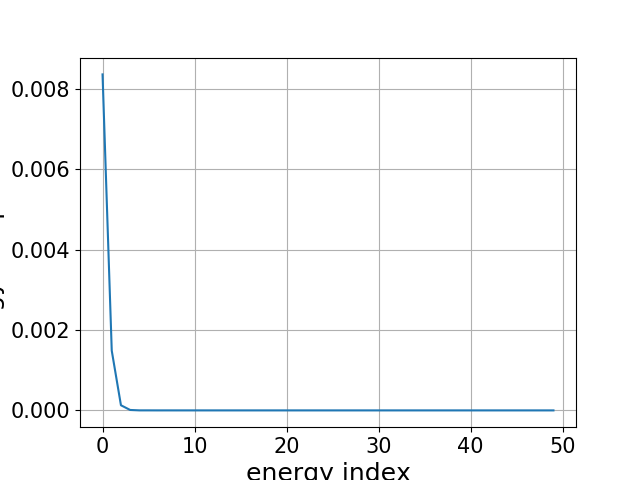

Text(0,0.5,'energy components')

In [17]:
fig, ax = plt.subplots()
energy_index = np.arange(N_energy)
energy_compotnent_sq = np.square(np.abs(psi_in_energy_representation))
ax.plot(energy_index, energy_compotnent_sq)
ax.set_xlabel('energy index')
ax.set_ylabel('energy components')

## Define temporal grid

In [18]:
## Parameters for temporal grid on which the wavefunction will be calculated.
N_time = 100
delta_t = 0.1
t_0 = 0.0

# Define temporal grid array
t_k = t_0 + np.arange(N_time) * delta_t

# Single summation is sufficient to obtain time-dependent solution
\begin{equation}
\psi(x_{n},t_{k})=\sum_{j}{c_{j}\psi_{j}\left(x_{n}\right)exp\left({-iE_{j}t_{k}/\hbar}\right)}
\end{equation}

In [19]:
## Construct time dependent term array

Eigen_values, T_k = np.meshgrid(eigen_values, t_k, indexing='ij')

time_dependent_term = np.exp(-1.0j * Eigen_values * T_k)

In [20]:
# Sum up to get \psi(x,t)
# Here, einstein constraction function is used. Can also be seen as simple tensor network
psi_x_t = np.einsum(eigen_vectors, [0,1], psi_in_energy_representation, [1], time_dependent_term, [1,2])

In [21]:
# A callable function is defined
# This function should get an integer, which is a frame index,
# and return a 1D array to be plotted

def get_frame_data(i):
    #return psi_x_t[:,i].real
    return np.square(np.absolute(psi_x_t[:,i]))

<IPython.core.display.Javascript object>


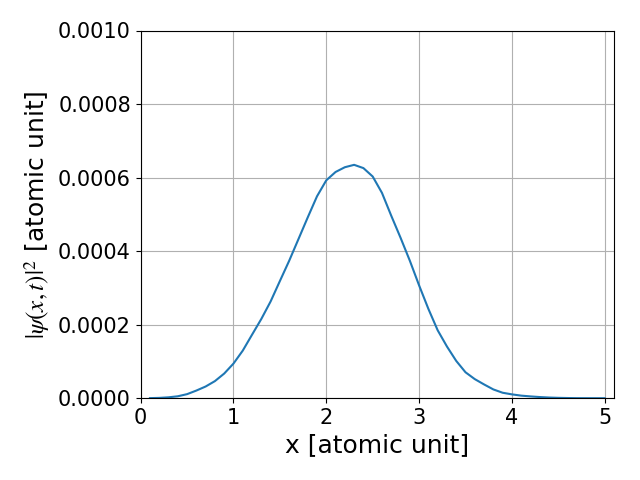

In [22]:
fig_ani = plt.figure()
ax_ani = fig_ani.gca()

line, = ax_ani.plot([],[])

ax_ani.set_xlim(x_min, x_max)
ax_ani.set_ylim(0, 0.001)
ax_ani.set_xlabel('x [atomic unit]')
ax_ani.set_ylabel(r'$|\psi(x,t)|^2$ [atomic unit]')

fig_ani.tight_layout()  # it makes the Axes fits into the Figure area

def update_line_data(frame_index):
    x = x_array
    y = get_frame_data(frame_index)
    line.set_data(x,y)
    return (line,)


from matplotlib.animation import FuncAnimation

ani = FuncAnimation(fig_ani, func=update_line_data)

# Save Animation

In [23]:
from matplotlib.animation import PillowWriter

ani.save('harmonic-oscillator.gif', writer=PillowWriter(fps=10))